# Identify Fraud from Enron email
## Machine Learning Project
___

### Tools library

In [131]:
#!/usr/bin/python

""" 
    A general tool for converting data from the
    dictionary format to an (n x k) python list that's 
    ready for training an sklearn algorithm

    n--no. of key-value pairs in dictonary
    k--no. of features being extracted

    dictionary keys are names of persons in dataset
    dictionary values are dictionaries, where each
        key-value pair in the dict is the name
        of a feature, and its value for that person

    In addition to converting a dictionary to a numpy 
    array, you may want to separate the labels from the
    features--this is what targetFeatureSplit is for

    so, if you want to have the poi label as the target,
    and the features you want to use are the person's
    salary and bonus, here's what you would do:

    feature_list = ["poi", "salary", "bonus"] 
    data_array = featureFormat( data_dictionary, feature_list )
    label, features = targetFeatureSplit(data_array)

    the line above (targetFeatureSplit) assumes that the
    label is the _first_ item in feature_list--very important
    that poi is listed first!
"""


import numpy as np
import pickle
import sys
from sklearn.cross_validation import StratifiedShuffleSplit
sys.path.append("../tools/")
#from feature_format import featureFormat, targetFeatureSplit

def featureFormat( dictionary, features, remove_NaN=True, remove_all_zeroes=True, remove_any_zeroes=False, sort_keys = False):
    """ convert dictionary to numpy array of features
        remove_NaN = True will convert "NaN" string to 0.0
        remove_all_zeroes = True will omit any data points for which
            all the features you seek are 0.0
        remove_any_zeroes = True will omit any data points for which
            any of the features you seek are 0.0
        sort_keys = True sorts keys by alphabetical order. Setting the value as
            a string opens the corresponding pickle file with a preset key
            order (this is used for Python 3 compatibility, and sort_keys
            should be left as False for the course mini-projects).
        NOTE: first feature is assumed to be 'poi' and is not checked for
            removal for zero or missing values.
    """


    return_list = []

    # Key order - first branch is for Python 3 compatibility on mini-projects,
    # second branch is for compatibility on final project.
    if isinstance(sort_keys, str):
        import pickle
        keys = pickle.load(open(sort_keys, "rb"))
    elif sort_keys:
        keys = sorted(dictionary.keys())
    else:
        keys = dictionary.keys()

    for key in keys:
        tmp_list = []
        for feature in features:
            try:
                dictionary[key][feature]
            except KeyError:
                print "error: key ", feature, " not present"
                return
            value = dictionary[key][feature]
            if value=="NaN" and remove_NaN:
                value = 0
            tmp_list.append( float(value) )

        # Logic for deciding whether or not to add the data point.
        append = True
        # exclude 'poi' class as criteria.
        if features[0] == 'poi':
            test_list = tmp_list[1:]
        else:
            test_list = tmp_list
        ### if all features are zero and you want to remove
        ### data points that are all zero, do that here
        if remove_all_zeroes:
            append = False
            for item in test_list:
                if item != 0 and item != "NaN":
                    append = True
                    break
        ### if any features for a given data point are zero
        ### and you want to remove data points with any zeroes,
        ### handle that here
        if remove_any_zeroes:
            if 0 in test_list or "NaN" in test_list:
                append = False
        ### Append the data point if flagged for addition.
        if append:
            return_list.append( np.array(tmp_list) )

    return np.array(return_list)


def targetFeatureSplit( data ):
    """ 
        given a numpy array like the one returned from
        featureFormat, separate out the first feature
        and put it into its own list (this should be the 
        quantity you want to predict)

        return targets and features as separate lists

        (sklearn can generally handle both lists and numpy arrays as 
        input formats when training/predicting)
    """

    target = []
    features = []
    for item in data:
        target.append( item[0] )
        features.append( item[1:] )

    return target, features

### Tester module

In [132]:
#!/usr/bin/pickle

""" a basic script for importing student's POI identifier,
    and checking the results that they get from it 
 
    requires that the algorithm, dataset, and features list
    be written to my_classifier.pkl, my_dataset.pkl, and
    my_feature_list.pkl, respectively

    that process should happen at the end of poi_id.py
"""

import pickle
import sys
from sklearn.cross_validation import StratifiedShuffleSplit
sys.path.append("../tools/")
#from feature_format import featureFormat, targetFeatureSplit

PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
\tFalse negatives: {:4d}\tTrue negatives: {:4d}"

def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    print labels
    print features
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    #print true_negatives, false_negatives, true_positives, false_positives
    
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print clf
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predicitons."

CLF_PICKLE_FILENAME = "my_classifier.pkl"
DATASET_PICKLE_FILENAME = "my_dataset.pkl"
FEATURE_LIST_FILENAME = "my_feature_list.pkl"

def dump_classifier_and_data(clf, dataset, feature_list):
    with open(CLF_PICKLE_FILENAME, "w") as clf_outfile:
        pickle.dump(clf, clf_outfile)
    with open(DATASET_PICKLE_FILENAME, "w") as dataset_outfile:
        pickle.dump(dataset, dataset_outfile)
    with open(FEATURE_LIST_FILENAME, "w") as featurelist_outfile:
        pickle.dump(feature_list, featurelist_outfile)

def load_classifier_and_data():
    with open(CLF_PICKLE_FILENAME, "r") as clf_infile:
        clf = pickle.load(clf_infile)
    with open(DATASET_PICKLE_FILENAME, "r") as dataset_infile:
        dataset = pickle.load(dataset_infile)
    with open(FEATURE_LIST_FILENAME, "r") as featurelist_infile:
        feature_list = pickle.load(featurelist_infile)
    return clf, dataset, feature_list

def main():
    ### load up student's classifier, dataset, and feature_list
    clf, dataset, feature_list = load_classifier_and_data()
    ### Run testing script
    test_classifier(clf, dataset, feature_list)

#if __name__ == '__main__':
#    main()


### Data exploration and cleaning

In [133]:
import matplotlib.pyplot as plt
import pandas as pd
% matplotlib inline

# Load data from pickle files:
with open('final_project_dataset.pkl', 'rb') as f:
    data_dict = pickle.load(f)

* **Basic statistics:**

In [134]:
print "Dataset type:", type(data_dict)
print "Number of key-value pairs in dictionary:", len(data_dict)
print "List of keys in dictionary:", data_dict.keys()
print "Number of elements in a key-value pair:", len(data_dict['SHANKMAN JEFFREY A'])
print "Example of contents of a key-value pair:", data_dict['SHANKMAN JEFFREY A']

Dataset type: <type 'dict'>
Number of key-value pairs in dictionary: 146
List of keys in dictionary: ['METTS MARK', 'BAXTER JOHN C', 'ELLIOTT STEVEN', 'CORDES WILLIAM R', 'HANNON KEVIN P', 'MORDAUNT KRISTINA M', 'MEYER ROCKFORD G', 'MCMAHON JEFFREY', 'HORTON STANLEY C', 'PIPER GREGORY F', 'HUMPHREY GENE E', 'UMANOFF ADAM S', 'BLACHMAN JEREMY M', 'SUNDE MARTIN', 'GIBBS DANA R', 'LOWRY CHARLES P', 'COLWELL WESLEY', 'MULLER MARK S', 'JACKSON CHARLENE R', 'WESTFAHL RICHARD K', 'WALTERS GARETH W', 'WALLS JR ROBERT H', 'KITCHEN LOUISE', 'CHAN RONNIE', 'BELFER ROBERT', 'SHANKMAN JEFFREY A', 'WODRASKA JOHN', 'BERGSIEKER RICHARD P', 'URQUHART JOHN A', 'BIBI PHILIPPE A', 'RIEKER PAULA H', 'WHALEY DAVID A', 'BECK SALLY W', 'HAUG DAVID L', 'ECHOLS JOHN B', 'MENDELSOHN JOHN', 'HICKERSON GARY J', 'CLINE KENNETH W', 'LEWIS RICHARD', 'HAYES ROBERT E', 'MCCARTY DANNY J', 'KOPPER MICHAEL J', 'LEFF DANIEL P', 'LAVORATO JOHN J', 'BERBERIAN DAVID', 'DETMERING TIMOTHY J', 'WAKEHAM JOHN', 'POWERS WILLIAM', '

This shows that the dataset is stored as a dictionary. Each person in the dataset is represented by a key-value pair. There are 146 such pairs.

The value is itself a dictionary containing 21 key-value pairs corresponding to the financial and email features.

* **Feature exploration:**
We first need to convert the dataset into a Panda dataframe for convenience. Since "NaN" seems to denote values equal to zero, I fill NAs with an epsilon value very close to zero (to avoid issues when using logarithmic scales).

In [135]:
features_list = ['poi', 'salary', 'bonus', 'long_term_incentive', 'deferred_income', 'deferral_payments', 
                 'loan_advances','other', 'expenses', 'director_fees', 'total_payments', 
                 'exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred', 'total_stock_value',
                 'from_messages', 'to_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 
                 'shared_receipt_with_poi']

data_df = pd.DataFrame.from_dict(data_dict, orient = 'index', dtype = float).fillna(0.00001)
data_df = data_df[features_list]
data_df.describe()

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,from_messages,to_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi
count,146.000000,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,146.000000,146.000000,146.000000,146.000000,146.000000
mean,0.123288,3.658114e+05,1.333474e+06,6.646839e+05,-3.827622e+05,4.387965e+05,1.149658e+06,5.854318e+05,7.074827e+04,1.942249e+04,4.350622e+06,4.182736e+06,1.749257e+06,2.051637e+04,5.846018e+06,358.602744,1221.589045,38.226032,24.287675,692.986305
std,0.329899,2.203575e+06,8.094029e+06,4.046072e+06,2.378250e+06,2.741325e+06,9.649342e+06,3.682345e+06,4.327163e+05,1.190543e+05,2.693448e+07,2.607040e+07,1.089995e+07,1.439661e+06,3.624681e+07,1441.259867,2226.770635,73.901122,79.278205,1072.969489
min,0.000000,1.000000e-05,1.000000e-05,1.000000e-05,-2.799289e+07,-1.025000e+05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,-2.604490e+06,-7.576788e+06,-4.409300e+04,0.000010,0.000010,0.000000,0.000000,0.000010
25%,0.000000,1.000000e-05,1.000000e-05,1.000000e-05,-3.792600e+04,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,9.394475e+04,1.000000e-05,8.115000e+03,1.000000e-05,2.288695e+05,0.000010,0.000010,0.000010,0.000010,0.000010
50%,0.000000,2.105960e+05,3.000000e+05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,9.595000e+02,2.018200e+04,1.000000e-05,9.413595e+05,6.082935e+05,3.605280e+05,1.000000e-05,9.659550e+05,16.500000,289.000000,2.500000,0.000010,102.500000
75%,0.000000,2.708505e+05,8.000000e+05,3.750648e+05,1.000000e-05,9.684500e+03,1.000000e-05,1.506065e+05,5.374075e+04,1.000000e-05,1.968287e+06,1.714221e+06,8.145280e+05,1.000000e-05,2.319991e+06,51.250000,1585.750000,40.750000,13.750000,893.500000
max,1.000000,2.670423e+07,9.734362e+07,4.852193e+07,1.000000e-05,3.208340e+07,8.392500e+07,4.266759e+07,5.235198e+06,1.398517e+06,3.098866e+08,3.117640e+08,1.303223e+08,1.545629e+07,4.345095e+08,14368.000000,15149.000000,528.000000,609.000000,5521.000000


`restricted_stock_deferred` seems to have negative values only according to `enron61702insiderpay.pdf`, however its maximum value is $15,456,290. Let's investigate:

In [136]:
data_df[data_df['restricted_stock_deferred'] == np.max(data_df['restricted_stock_deferred'])]

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,from_messages,to_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi
BHATNAGAR SANJAY,0.0,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,137864.0,0.00001,137864.0,15456290.0,2604490.0,-2604490.0,15456290.0,0.00001,29.0,523.0,0.0,1.0,463.0


When comparing these values with the pdf file, I realize that the data is shifted to the left by one column, hence the errors. Presumably, there might be other such occurences so I now need to go through the data and manually fix these.

* **Data cleaning:**
An easy way to detect discrepancies such as described above is to check that totals (payments and stock value) are equal to the sum of their components.

In [137]:
data_df[(np.floor(data_df['salary'] + data_df['bonus'] + data_df['long_term_incentive'] + data_df['deferred_income'] + \
       data_df['deferral_payments'] + data_df['loan_advances'] + data_df['other'] + data_df['expenses'] + \
       data_df['director_fees']) != np.floor(data_df['total_payments'])) | \
       (np.floor(data_df['exercised_stock_options'] + data_df['restricted_stock'] + \
        data_df['restricted_stock_deferred']) != np.floor(data_df['total_stock_value']))]

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,from_messages,to_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi
BELFER ROBERT,0.0,0.00001,0.00001,0.00001,0.00001,-102500.00000,0.00001,0.00001,0.00001,3285.0,102500.0,3285.0,1.000000e-05,44093.0,-44093.00000,0.00001,0.00001,0.00001,0.00001,0.00001
BHATNAGAR SANJAY,0.0,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,137864.00000,0.00001,137864.0,15456290.0,2604490.0,-2.604490e+06,15456290.0,0.00001,29.00000,523.00000,0.00000,1.00000,463.00000


There are only two problematic observations. Let's correct them manually:

In [138]:
# Robert Belfer:
for j in xrange(1, 14):
    data_df.ix['BELFER ROBERT', j] = data_df.ix['BELFER ROBERT', j + 1]
data_df.ix['BELFER ROBERT', 14] = 1.e-5

# Sanjay Bhatnagar:
for j in xrange(14, 2, -1):
    data_df.ix['BHATNAGAR SANJAY', j] = data_df.ix['BHATNAGAR SANJAY', j - 1]
data_df.ix['BHATNAGAR SANJAY', 1] = 1.e-5
    
data_df.loc[['BELFER ROBERT', 'BHATNAGAR SANJAY']]

/home/lucfrachon/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  app.launch_new_instance()


,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,from_messages,to_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi
BELFER ROBERT,0.0,0.00001,0.00001,0.00001,-102500.00000,0.00001,0.00001,0.00001,3285.0,102500.00000,3285.0,1.000000e-05,44093.0,-44093.0,1.000000e-05,0.00001,0.00001,0.00001,0.00001,0.00001
BHATNAGAR SANJAY,0.0,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,137864.0,0.00001,137864.0,1.545629e+07,2604490.0,-2604490.0,1.545629e+07,29.00000,523.00000,0.00000,1.00000,463.00000


This confirms we successfully cleaned up the data.

- Look for outliers:

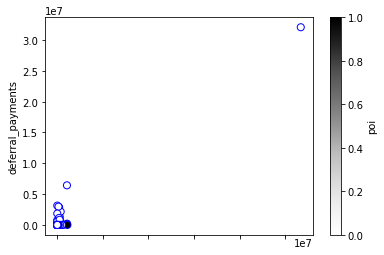

In [139]:
sp = data_df.plot.scatter(x = 'salary', y = 'deferral_payments', c = 'poi', edgecolors = 'Blue', 
                          s = 50)

There is an observation that immediately stands out. It corresponds to the highest values of both `salary` and `deferral_payments`. When checking the numbers against the document named `enron61702insiderpay.pdf`, we see that these values correspond to the 'TOTAL' line and are therefore an artefact of the data collection process rather than an actual observation.

In [140]:
# Drop the 'TOTAL' row:
data_df = data_df.drop(['TOTAL'])
data_df.describe()

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,from_messages,to_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi
count,145.000000,1.450000e+02,1.450000e+02,1.450000e+02,1.450000e+02,1.450000e+02,1.450000e+02,1.450000e+02,145.000000,145.000000,1.450000e+02,1.450000e+02,1.450000e+02,1.450000e+02,1.450000e+02,145.000000,145.000000,145.000000,145.000000,145.000000
mean,0.124138,1.841671e+05,6.713353e+05,3.346340e+05,-1.930544e+05,2.212648e+05,5.787931e+05,2.942592e+05,36104.813796,9644.944837,2.137149e+06,2.150097e+06,8.987745e+05,-5.225371e+04,2.996617e+06,361.075866,1230.013797,38.489659,24.455176,697.765521
std,0.330882,1.969598e+05,1.230148e+06,6.853639e+05,6.039507e+05,7.514469e+05,6.771012e+06,1.127596e+06,45929.788821,30327.443493,8.750086e+06,4.909489e+06,1.994815e+06,2.722683e+05,6.254735e+06,1445.944683,2232.153000,74.088357,79.527071,1075.128123
min,0.000000,1.000000e-05,1.000000e-05,1.000000e-05,-3.504386e+06,1.000000e-05,1.000000e-05,1.000000e-05,0.000010,0.000010,1.000000e-05,1.000000e-05,1.000000e-05,-2.604490e+06,1.000000e-05,0.000010,0.000010,0.000000,0.000000,0.000010
25%,0.000000,1.000000e-05,1.000000e-05,1.000000e-05,-3.834600e+04,1.000000e-05,1.000000e-05,1.000000e-05,0.000010,0.000010,8.749200e+04,1.000000e-05,4.409300e+04,1.000000e-05,2.520550e+05,0.000010,0.000010,0.000010,0.000010,0.000010
50%,0.000000,2.105000e+05,3.000000e+05,1.000000e-05,1.000000e-05,1.000000e-05,1.000000e-05,8.910000e+02,21530.000000,0.000010,9.114530e+05,6.078370e+05,3.605280e+05,1.000000e-05,9.760370e+05,17.000000,312.000000,4.000000,0.000010,114.000000
75%,0.000000,2.690760e+05,8.000000e+05,3.743470e+05,1.000000e-05,7.961000e+03,1.000000e-05,1.504580e+05,53947.000000,0.000010,1.868758e+06,1.668260e+06,8.530640e+05,1.000000e-05,2.332399e+06,52.000000,1607.000000,41.000000,14.000000,900.000000
max,1.000000,1.111258e+06,8.000000e+06,5.145434e+06,1.000000e-05,6.426990e+06,8.152500e+07,1.035973e+07,228763.000000,125034.000000,1.035598e+08,3.434838e+07,1.476169e+07,1.000000e-05,4.911008e+07,14368.000000,15149.000000,528.000000,609.000000,5521.000000


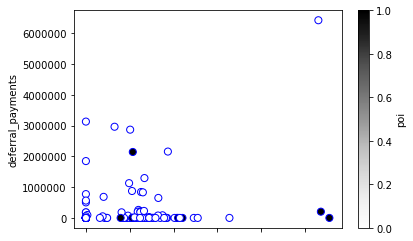

In [141]:
sp = data_df.plot.scatter(x = 'salary', y = 'deferral_payments', c = 'poi', edgecolors = 'Blue', 
                          s = 50)

The data looks a lot more sensible now. There are still two significant outliers but they correspond to actual staff members (Jeffrey Skelling and Mark Frevert). As often with financial data, we might need to opt for log scales in further exploration. But for now, we are trying to identify outliers so we will stick to linear scales.
Let's continue to plot observations:

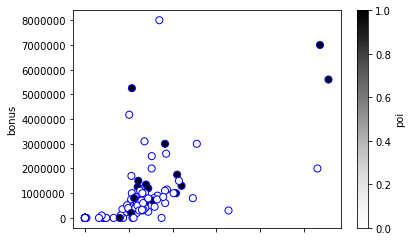

In [142]:
sp = data_df.plot.scatter(x = 'salary', y = 'bonus', c = 'poi', edgecolors = 'Blue', 
                          s = 50)

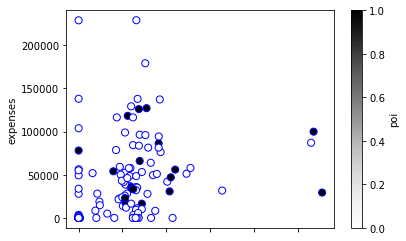

In [143]:
sp = data_df.plot.scatter(x = 'salary', y = 'expenses', c = 'poi', edgecolors = 'Blue', 
                          s = 50)

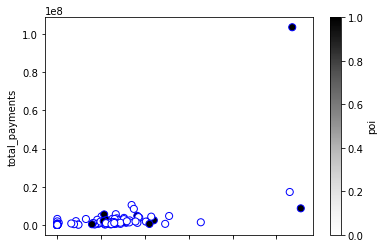

In [144]:
sp = data_df.plot.scatter(x = 'salary', y = 'total_payments', c = 'poi', edgecolors = 'Blue', 
                          s = 50)

Wow, now we have someone whose total payments is one order of magnitude above everyone else's. This is Kenneth Lay; the bulk of the payments come from Loan Advances. We will need to make a decision as to whether we want to keep him in the data or not... Let's see what this plot looks like with a logarithmic y-scale:

(10000.0, 150000000.0)

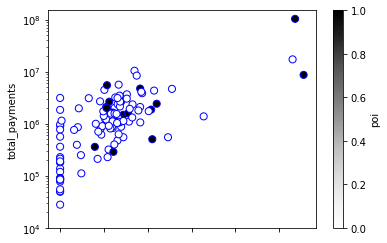

In [145]:
sp = data_df.plot.scatter(x = 'salary', y = 'total_payments', c = 'poi', edgecolors = 'Blue', 
                          s = 50)
sp.set_yscale('log')
sp.set_ylim(1.0e4, 1.5e8)

Now there seems to be a correlation between the two variables.

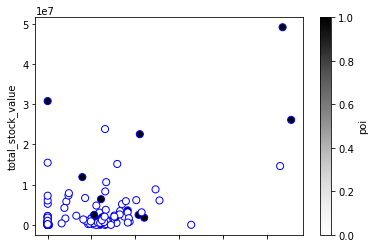

In [146]:
sp = data_df.plot.scatter(x = 'salary', y = 'total_stock_value', c = 'poi', edgecolors = 'Blue', 
                          s = 50)

Again, Kenneth Lay stands out with a total stock value of over $49mil. This is a real observations, so I decide to keep it for now.

(10000.0, 150000000.0)

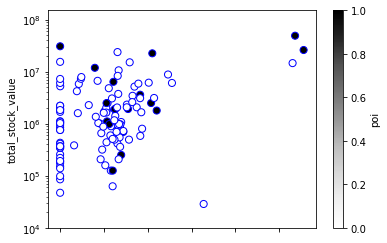

In [147]:
sp = data_df.plot.scatter(x = 'salary', y = 'total_stock_value', c = 'poi', edgecolors = 'Blue', 
                          s = 50)
sp.set_yscale('log')
sp.set_ylim(1.0e4, 1.5e8)

The two variables seem associated but the relationship may not be linear, even taking the log of `total_stock_value`.

Let's now look at email features:

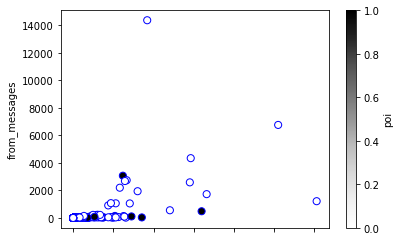

In [148]:
sp = data_df.plot.scatter(x = 'to_messages', y = 'from_messages', c = 'poi', edgecolors = 'Blue', 
                          s = 50)

One employee stands out as extremely verbose! They sent almost 3 times as many messages as they received. Let's find out who they were:

In [149]:
data_df[data_df['from_messages'] == np.max(data_df['from_messages'])]

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,from_messages,to_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi
KAMINSKI WINCENTY J,0.0,275101.0,400000.0,323466.0,0.00001,0.00001,0.00001,4669.0,83585.0,0.00001,1086821.0,850010.0,126027.0,0.00001,976037.0,14368.0,4607.0,41.0,171.0,583.0


The Wikipedia page about Vince Kaminski tells us he was Managing Director for Research and repetedly voiced objections to Enron's practices, warning that a single event could trigger a cascade of provision clauses in creditor contracts that would quickly lead to the demise of Enron. He was unfortunately proved right... Would this explain the discrepancy between the number of emails sent andb received? A detailed analysis of his emails might give us some insight into this but this is outside the scope of this project.

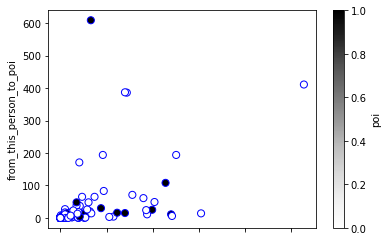

In [150]:
sp = data_df.plot.scatter(x = 'from_poi_to_this_person', y = 'from_this_person_to_poi',
                          c = 'poi', edgecolors = 'Blue', 
                          s = 50)

Again, let's look at who the two outliers are:

In [151]:
data_df[data_df['from_this_person_to_poi'] == np.max(data_df['from_this_person_to_poi'])]

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,from_messages,to_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi
DELAINEY DAVID W,1.0,365163.0,3000000.0,1294981.0,0.00001,0.00001,0.00001,1661.0,86174.0,0.00001,4747979.0,2291113.0,1323148.0,0.00001,3614261.0,3069.0,3093.0,66.0,609.0,2097.0


In [152]:
data_df[data_df['from_poi_to_this_person'] == np.max(data_df['from_poi_to_this_person'])]

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,from_messages,to_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi
LAVORATO JOHN J,0.0,339288.0,8000000.0,2035380.0,0.00001,0.00001,0.00001,1552.0,49537.0,0.00001,10425757.0,4158995.0,1008149.0,0.00001,5167144.0,2585.0,7259.0,528.0,411.0,3962.0


David Delainey is a POI; in fact he was amongst the first convicted employees of Enron. John Lavorato is not a POI, and seems to have privately expressed concerns about some of Enron's behaviour.

* **Look at individual variable distributions:**

In this section we will plot histograms for each feature variable and apply log transformations where required to make them closer to a normal distribution, which helps many machine learning models.

(0, 20)

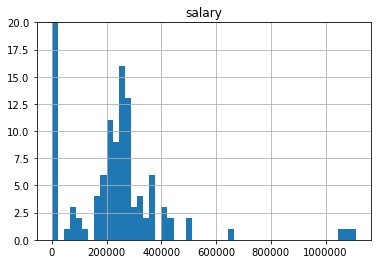

In [153]:
fig, ax = plt.subplots()
data_df.hist('salary', ax = ax, bins = 50)
ax.set_ylim(0, 20)

Many salaries are 0 -- presumably, not current Enron employees. Salaries are distributed in a fairly normal way, if we exclude the 0 values.

(0, 10)

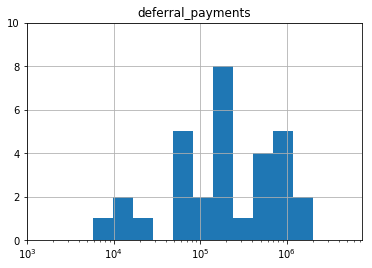

In [154]:
fig, ax = plt.subplots()
data_df.hist('deferral_payments', ax = ax, bins = np.logspace(np.log10(1.e-5),
                                                              np.log10(2.e6),
                                                              50))
ax.set_xscale('log')
ax.set_xlim(1e3, None)
ax.set_ylim(0, 10)

For `deferral_payments`, I had to use a log transformation to get something resembling a normal distribution. Note that the count of non-zero values is low.

(0, 33.600000000000001)

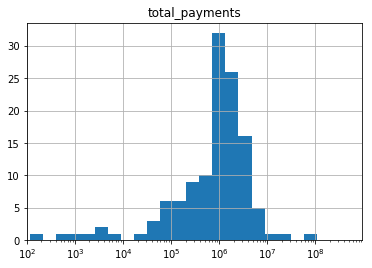

In [155]:
fig, ax = plt.subplots()
data_df.hist('total_payments', ax = ax, bins = np.logspace(np.log10(1.e-5),
                                                              np.log10(2.e8),
                                                              50))
ax.set_xscale('log')
ax.set_xlim(1.e2, None)
ax.set_ylim(0, None)

Again, a logarithmic transformation is required to have a roughly normal distribution of the non-zero values.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f671f799910>], dtype=object)

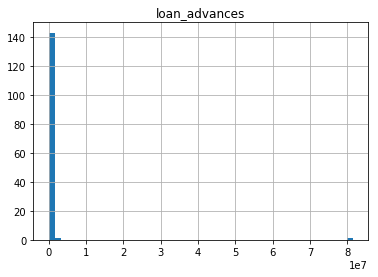

In [156]:
fig, ax = plt.subplots()
data_df.hist('loan_advances', ax = ax, bins = 50)

The number of non-zero values does not justify using this predictor in the model.

(0, 20)

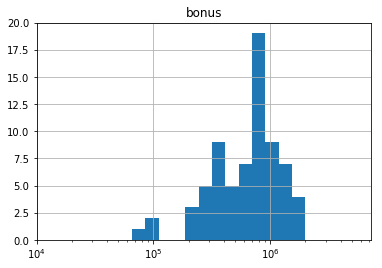

In [157]:
fig, ax = plt.subplots()
data_df.hist('bonus', ax = ax, bins = np.logspace(np.log10(1.e-5),
                                                              np.log10(2.e6),
                                                              100))
ax.set_xscale('log')
ax.set_xlim(1e4, None)
ax.set_ylim(0, 20)

Here again, I used a log transformation.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f671fbbf050>], dtype=object)

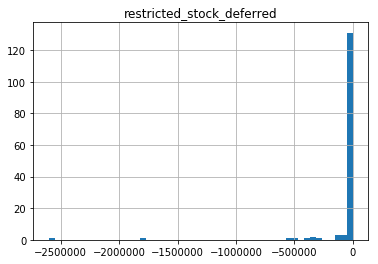

In [158]:
fig, ax = plt.subplots()
data_df.hist('restricted_stock_deferred', ax = ax, bins = 50)

* **Look for associations between features and labels:**

In this section, we will boxplot the `poi` label against the feature variables to try and find the most relevant features to select in our model.

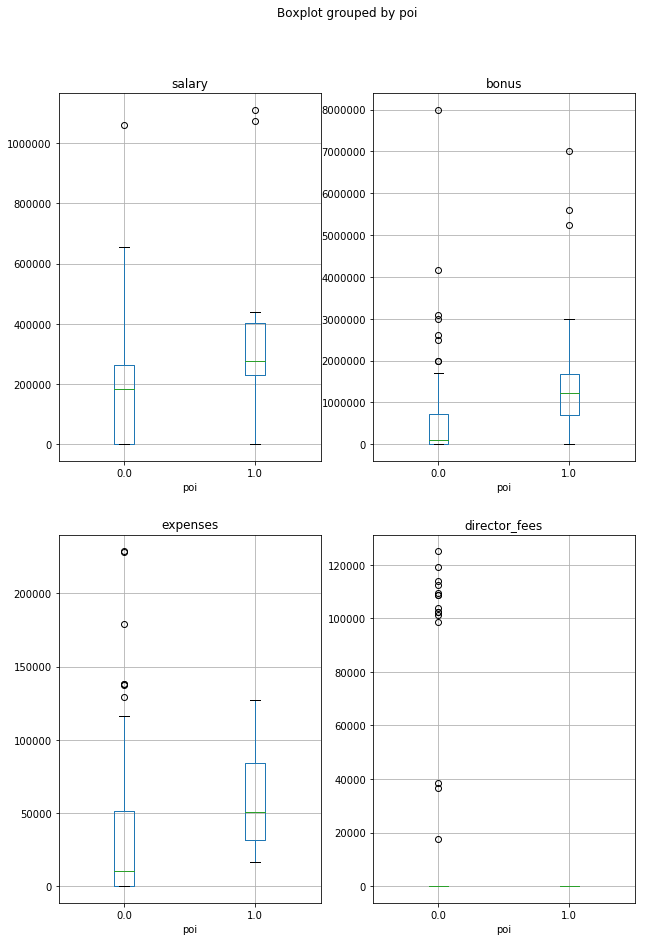

In [159]:
fig, ax = plt.subplots(2, 2, sharey = False, figsize = (10, 15))
bp = data_df.boxplot(['salary', 'bonus', 'expenses', 'director_fees'], by = 'poi', 
                      ax = ax)

It looks like `salary` and `bonus` might be good predictors. `expenses` seem less significant.
Finally, `director_fees` seems useful because none of the POI seems to have received any director fees. However, this also applies to many non-POIs so it is not enough for perfect prediction. Moreover, very few employees received these fees so the information might not be very significant.

In [160]:
data_df.loc[:, ['director_fees', 'poi']]

,director_fees,poi
ALLEN PHILLIP K,0.00001,0.0
BADUM JAMES P,0.00001,0.0
BANNANTINE JAMES M,0.00001,0.0
BAXTER JOHN C,0.00001,0.0
BAY FRANKLIN R,0.00001,0.0
BAZELIDES PHILIP J,0.00001,0.0
BECK SALLY W,0.00001,0.0
BELDEN TIMOTHY N,0.00001,1.0
BELFER ROBERT,102500.00000,0.0
BERBERIAN DAVID,0.00001,0.0


Let's continue our investigation with the next set of predictors. For these predictors, a logarithmic y scale is more adequate:

In [161]:
data_df.loc[:, 'deferred_income'] = np.abs(data_df.loc[:, 'deferred_income'])

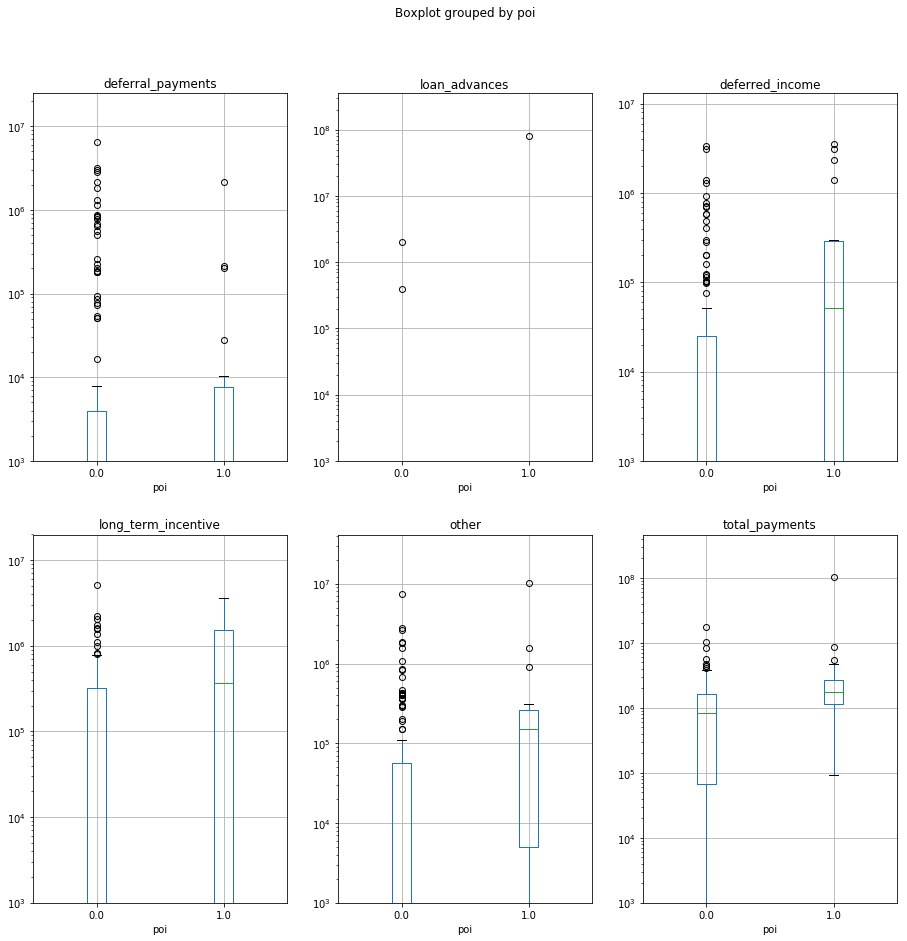

In [162]:
fig, axes = plt.subplots(2, 3, sharey = False, figsize = (15, 15))
bp = data_df.boxplot(['deferral_payments', 'loan_advances', 'deferred_income', 
                       'long_term_incentive', 'other', 'total_payments'], by = 'poi', 
                      ax = axes)
for i in range(2):
    for j in range(3):
        axes[i][j].set_yscale('log')
        axes[i][j].set_ylim(1000, None)

Some of these variables have very few non-zero values, such as loan advances for instance. `deferral_payment` might not be a very strong predictor, but the other variables seem all significant. However we need to be warry of not duplicating information, so we should probably not include `total_payments` (which is the sum of all other pay-related features), or conversely we should only keep the total but not (all) the elements making it up.

Let's continue with the stock value features:

In [163]:
data_df.loc[:, 'restricted_stock_deferred'] = np.abs(data_df.loc[:, 'restricted_stock_deferred'])

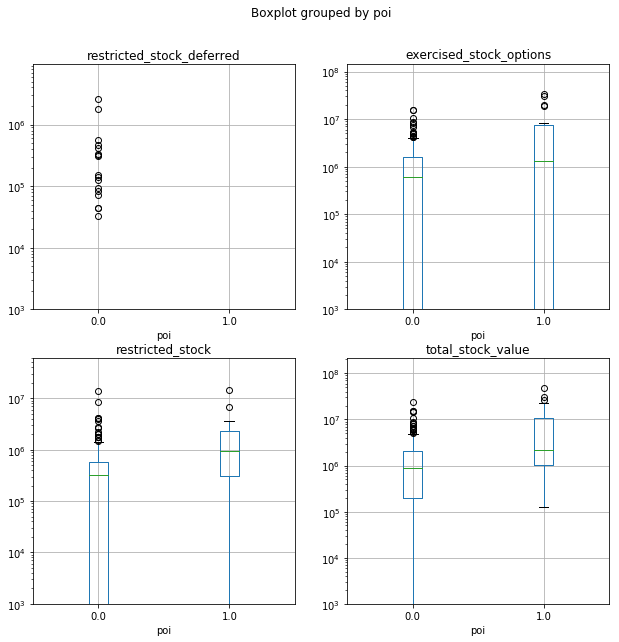

In [164]:
fig, axes = plt.subplots(2, 2, sharey = False, figsize = (10, 10))
bp = data_df.boxplot(['restricted_stock_deferred', 'exercised_stock_options', 
                      'restricted_stock', 'total_stock_value'], by = 'poi', 
                      ax = axes)
for i in range(2):
    for j in range(2):
        axes[i][j].set_yscale('log')
        axes[i][j].set_ylim(1000, None)

It appears that only non-POI have non-zero values for `restricted_stock_deferred`. However the number of non-zero observations is low. The other predictors all seem useful, but `total_stock_value` is the sum of all of them so we may need to choose whether to keep the total or the individual predictors that make it up.

Finally, let's have a look at the email features:

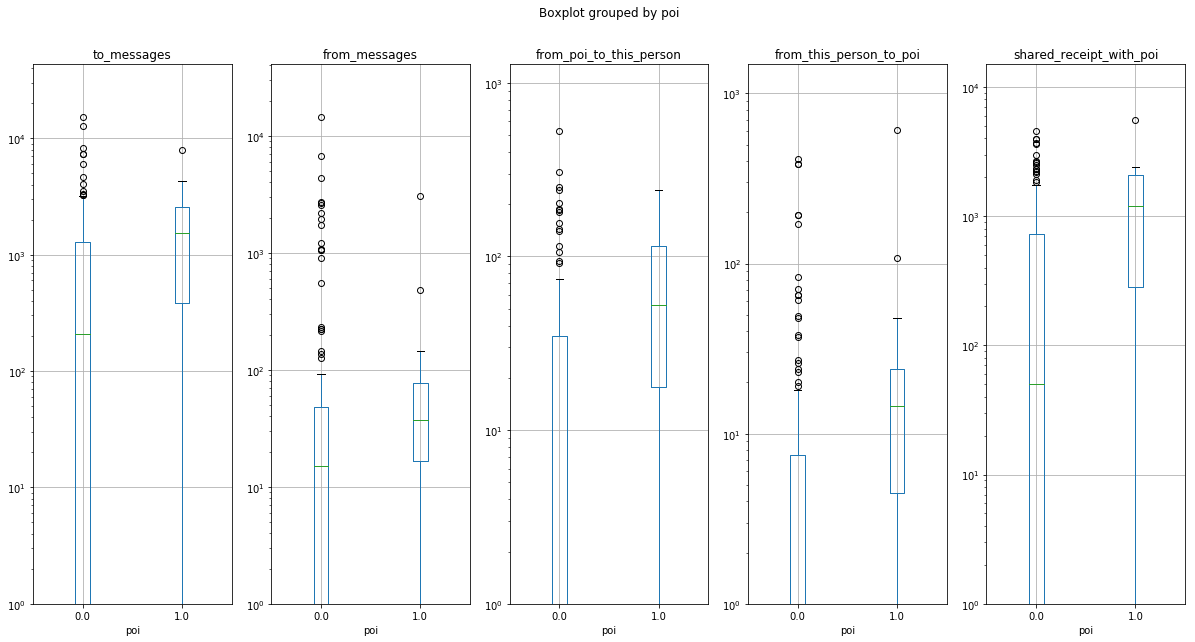

In [165]:
fig, axes = plt.subplots(1, 5, sharey = False, figsize = (20, 10))
bp = data_df.boxplot(['to_messages', 'from_messages', 'from_poi_to_this_person', 
                      'from_this_person_to_poi', 'shared_receipt_with_poi'], by = 'poi', 
                      ax = axes)
for i in range(5):
    axes[i].set_yscale('log')
    axes[i].set_ylim(1, None)

All these predictors seem relevant to predict the POI status of a member of staff.
Note that there seems to be a circular logic in these features: To predict whether or not someone is a POI, we look at whether they sent emails or received emails from other POIs, which implies that we already know if they are POIs or not...

### Synthetic features

Given the small dataset size, I would like to restrict the number of predictors to as low a number as possible. To that end, I will try to aggregate some of the variables in a meaningful way.
My first idea is to use the email features to look at from / to ratios and total number of emails involving POIs.

In [166]:
#extended_data = data_df.loc[:, ['poi', 'salary', 'expenses', 'director_fees', 'shared_receipt_with_poi']]
extended_data = data_df.loc[:, ['poi', 'salary', 'bonus', 'expenses', 'director_fees']]
extended_data.loc[:, 'sent_vs_received'] = data_df.loc[:, 'from_messages'] / data_df.loc[:, 'to_messages']
extended_data.loc[:, 'total_emails']= data_df.loc[:, 'from_messages'] + data_df.loc[:, 'to_messages']
extended_data.loc[:, 'emails_with_poi'] = data_df.loc[:, 'from_this_person_to_poi'] + \
    data_df.loc[:, 'from_poi_to_this_person'] + \
    data_df.loc[:, 'shared_receipt_with_poi']

Let's see if these variables teach us anything:

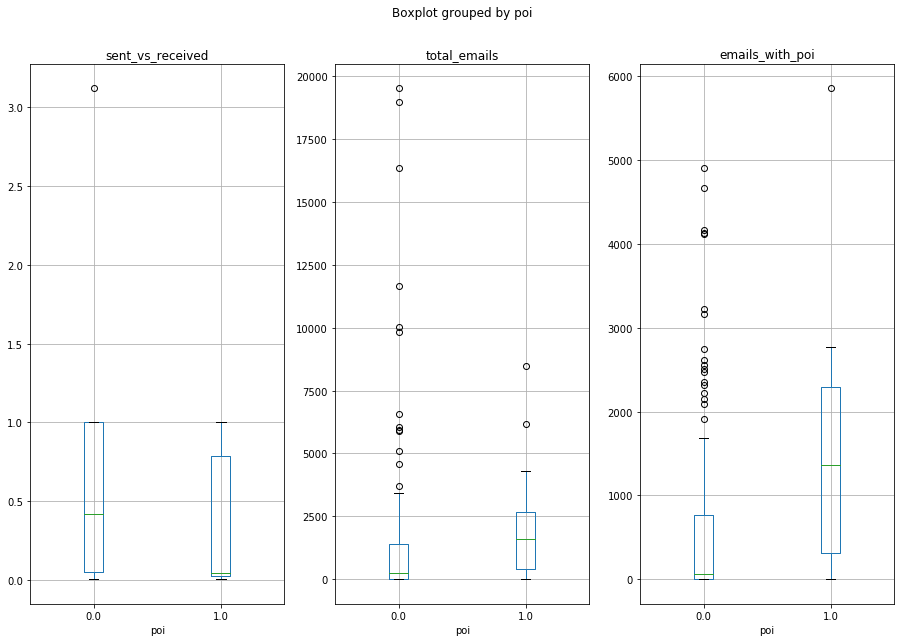

In [167]:
fig, axes = plt.subplots(1, 3, sharey = False, figsize = (15, 10))
bp = extended_data.boxplot(['sent_vs_received', 'total_emails', 'emails_with_poi'], by = 'poi', 
                           ax = axes)

The boxes for POI / non-POI in the first plot overlap quite a lot, meaning the predictor might not be as useful as others, but median values are quite diffent. It seems that on average, POI tend to send far less emails than they receive, which is intuitively consistent with senior executives being cc'd on a lot of conversations.

### Feature selection

Based on the analysis above, I will make a feature selection for my first model, bearing in mind the need to keep the feature count as low as possible. There are also some variables that need to be converted to their logarithmic values.

Selected features:

* `salary`
* log(`bonus`)
* `expenses`
* `director_fees`
* log(`deferred_income`)
* log(`long_term_incentive`)
* log(`other`)
* log(`restricted_stock_deferred`)
* log(`total_stock_value`)
* `sent_vs_received`
* `total_emails`
* `emails_with_poi`

In [168]:
# Create and export final dataset
extended_data.loc[:, 'log_bonus'] =  np.log(data_df.loc[:, 'bonus'])
extended_data.loc[:, 'log_deferred_income'] =  np.log(data_df.loc[:, 'deferred_income'])
extended_data.loc[:, 'log_long_term_incentive'] =  np.log(data_df.loc[:, 'long_term_incentive'])
extended_data.loc[:, 'log_other'] =  np.log(data_df.loc[:, 'other'])
extended_data.loc[:, 'log_restricted_stock_deferred'] =  np.log(data_df.loc[:, 'restricted_stock_deferred'])
extended_data.loc[:, 'log_total_stock_value'] =  np.log(data_df.loc[:, 'total_stock_value'])

# List of features used in the model
features_list = list(extended_data.columns)

# Put dataset into the dict format expected by the test module
my_data_dict = extended_data.to_dict(orient = 'index')

print features_list

['poi', 'salary', 'bonus', 'expenses', 'director_fees', 'sent_vs_received', 'total_emails', 'emails_with_poi', 'log_bonus', 'log_deferred_income', 'log_long_term_incentive', 'log_other', 'log_restricted_stock_deferred', 'log_total_stock_value']


In [169]:
# Data and features export
with open('my_dataset.pkl', 'wb') as f:
    pickle.dump(my_data_dict, f)
with open('my_features.pkl', 'wb') as g:
    pickle.dump(features_list, g)

In [170]:
# Apply starter code functions to retrieve the data
with open('my_dataset.pkl', 'rb') as f:
    my_data_dict = pickle.load(f)
with open('my_features.pkl', 'rb') as g:
    features_list = pickle.load(g)

### Extract features and labels from dataset for local testing
data = featureFormat(my_data_dict, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

### Machine Learning Classifier

Now that we have a clean dataset with carefully selected predictors, let's build a classifier. We can try a Support Machine Vector classifier first:

* **SVC**:

    - Meta parameters:

In [181]:
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV


seed = 42

# SVC parameter grid:
grid = {'gamma': np.logspace(-9, 5, 15, base = 2.), 'C': np.logspace(-9, 5, 15, base = 2.)}

# Scale variables:
#scaler = RobustScaler()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# SVC:
svc = SVC()

# Cross-validation:
cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.3, random_state = seed * 2)
gscv = GridSearchCV(svc, param_grid = grid, scoring = 'f1', cv = cv, verbose = 3, n_jobs = 3)

# Fit model:
gscv.fit(scaled_features, labels)

print "Best parameters:", gscv.best_params_
print "CV F1-Score:", gscv.best_score_

Fitting 10 folds for each of 225 candidates, totalling 2250 fits
[CV] C=0.001953125, gamma=0.001953125 ................................
[CV] C=0.001953125, gamma=0.001953125 ................................
[CV] C=0.001953125, gamma=0.001953125 ................................


/home/lucfrachon/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lucfrachon/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.001953125, gamma=0.001953125, score=0.000000, total=   0.0s


/home/lucfrachon/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.001953125, gamma=0.001953125 ................................
[CV] . C=0.001953125, gamma=0.001953125, score=0.000000, total=   0.0s
[CV] C=0.001953125, gamma=0.001953125 ................................
[CV] . C=0.001953125, gamma=0.001953125, score=0.000000, total=   0.0s
[CV] . C=0.001953125, gamma=0.001953125, score=0.000000, total=   0.0s
[CV] C=0.001953125, gamma=0.001953125 ................................
[CV] . C=0.001953125, gamma=0.001953125, score=0.000000, total=   0.0s
[CV] . C=0.001953125, gamma=0.001953125, score=0.000000, total=   0.0s
[CV] C=0.001953125, gamma=0.001953125 ................................
[CV] . C=0.001953125, gamma=0.001953125, score=0.000000, total=   0.0s
[CV] C=0.001953125, gamma=0.001953125 ................................
[CV] C=0.001953125, gamma=0.0078125 ..................................
[CV] C=0.001953125, gamma=0.00390625 .................................
[CV] .. C=0.001953125, gamma=0.00390625, score=0.000000, total=   0.0s
[CV] .

[Parallel(n_jobs=3)]: Done 514 tasks      | elapsed:    1.8s


[CV] C=0.03125, gamma=0.03125 ........................................
[CV] ......... C=0.03125, gamma=0.03125, score=0.000000, total=   0.0s
[CV] ....... C=0.03125, gamma=0.0078125, score=0.000000, total=   0.0s
[CV] C=0.03125, gamma=0.015625 .......................................
[CV] C=0.03125, gamma=0.03125 ........................................
[CV] ........ C=0.03125, gamma=0.015625, score=0.000000, total=   0.0s
[CV] ......... C=0.03125, gamma=0.03125, score=0.000000, total=   0.0s
[CV] C=0.03125, gamma=0.03125 ........................................
[CV] ........ C=0.03125, gamma=0.015625, score=0.000000, total=   0.0s
[CV] C=0.015625, gamma=32.0 ..........................................
[CV] ......... C=0.03125, gamma=0.03125, score=0.000000, total=   0.0s
[CV] C=0.03125, gamma=0.015625 .......................................
[CV] C=0.03125, gamma=0.03125 ........................................
[CV] ......... C=0.03125, gamma=0.03125, score=0.000000, total=   0.0s
[CV] .

[Parallel(n_jobs=3)]: Done 2250 out of 2250 | elapsed:    7.3s finished


In [182]:
from sklearn.pipeline import Pipeline

seed = 42

# Define pipeline:
clf = Pipeline(steps = [('scaler', scaler), ('svc', svc)])
clf.set_params(svc__C = gscv.best_params_['C'], svc__gamma = gscv.best_params_['gamma'])

# Fit model:
#gscv.fit(features, labels)
clf.fit(features, labels)

#print "Best parameters:", gscv.best_params_
#print "CV F1-Score:", gscv.best_score_
print "Score:", clf.score(features, labels)


Score: 1.0


We now have the optimal parameters for the SVM classifier. Let's refit the model on the training set and check the testing accuracy.

In [183]:
#!/usr/bin/pickle

""" a basic script for importing student's POI identifier,
    and checking the results that they get from it 
 
    requires that the algorithm, dataset, and features list
    be written to my_classifier.pkl, my_dataset.pkl, and
    my_feature_list.pkl, respectively

    that process should happen at the end of poi_id.py
"""

import pickle
import sys
from sklearn.cross_validation import StratifiedShuffleSplit
sys.path.append("../tools/")
#from feature_format import featureFormat, targetFeatureSplit

PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
\tFalse negatives: {:4d}\tTrue negatives: {:4d}"

def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    #print true_negatives, false_negatives, true_positives, false_positives
    
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print clf
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predicitons."

CLF_PICKLE_FILENAME = "my_classifier.pkl"
DATASET_PICKLE_FILENAME = "my_dataset.pkl"
FEATURE_LIST_FILENAME = "my_feature_list.pkl"

def dump_classifier_and_data(clf, dataset, feature_list):
    with open(CLF_PICKLE_FILENAME, "w") as clf_outfile:
        pickle.dump(clf, clf_outfile)
    with open(DATASET_PICKLE_FILENAME, "w") as dataset_outfile:
        pickle.dump(dataset, dataset_outfile)
    with open(FEATURE_LIST_FILENAME, "w") as featurelist_outfile:
        pickle.dump(feature_list, featurelist_outfile)

def load_classifier_and_data():
    with open(CLF_PICKLE_FILENAME, "r") as clf_infile:
        clf = pickle.load(clf_infile)
    with open(DATASET_PICKLE_FILENAME, "r") as dataset_infile:
        dataset = pickle.load(dataset_infile)
    with open(FEATURE_LIST_FILENAME, "r") as featurelist_infile:
        feature_list = pickle.load(featurelist_infile)
    return clf, dataset, feature_list

def main():
    ### load up student's classifier, dataset, and feature_list
    clf, dataset, feature_list = load_classifier_and_data()
    ### Run testing script
    test_classifier(clf, dataset, feature_list)

#if __name__ == '__main__':
#    main()


In [184]:
test_classifier(clf, my_data_dict, features_list, folds = 1000)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=8.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
	Accuracy: 0.92540	Precision: 0.84877	Recall: 0.53600	F1: 0.65706	F2: 0.57865
	Total predictions: 15000	True positives: 1072	False positives:  191	False negatives:  928	True negatives: 12809



* **Random Forest Classifier:**

In [185]:
from sklearn.ensemble import RandomForestClassifier

# Define pipeline:
## RF parameter grid:
grid = {'n_estimators': [85, 90, 95, 100, 110], 'max_features': [4, 5, 6, 7]}
## Scale variables:
#scaler = RobustScaler()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

## Random Forest:
rf = RandomForestClassifier()
## Cross-validation:
gscv = GridSearchCV(rf, param_grid = grid, scoring = 'f1', cv = cv, verbose = 3, n_jobs = 3)

# Fit model:
gscv.fit(scaled_features, labels)

print "Best parameters:", gscv.best_params_
print "CV F1-Score:", gscv.best_score_

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] max_features=4, n_estimators=85 .................................
[CV] max_features=4, n_estimators=85 .................................
[CV] max_features=4, n_estimators=85 .................................
[CV] .. max_features=4, n_estimators=85, score=0.333333, total=   0.3s
[CV] max_features=4, n_estimators=85 .................................
[CV] .. max_features=4, n_estimators=85, score=0.000000, total=   0.3s
[CV] max_features=4, n_estimators=85 .................................
[CV] .. max_features=4, n_estimators=85, score=0.250000, total=   0.3s
[CV] max_features=4, n_estimators=85 .................................


/home/lucfrachon/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. max_features=4, n_estimators=85, score=0.000000, total=   0.3s
[CV] max_features=4, n_estimators=85 .................................
[CV] .. max_features=4, n_estimators=85, score=0.222222, total=   0.3s
[CV] max_features=4, n_estimators=85 .................................
[CV] .. max_features=4, n_estimators=85, score=0.285714, total=   0.3s
[CV] max_features=4, n_estimators=85 .................................
[CV] .. max_features=4, n_estimators=85, score=0.200000, total=   0.2s
[CV] max_features=4, n_estimators=85 .................................
[CV] .. max_features=4, n_estimators=85, score=0.285714, total=   0.2s
[CV] max_features=4, n_estimators=90 .................................
[CV] .. max_features=4, n_estimators=85, score=0.363636, total=   0.3s
[CV] max_features=4, n_estimators=90 .................................
[CV] .. max_features=4, n_estimators=85, score=0.250000, total=   0.2s
[CV] max_features=4, n_estimators=90 .................................
[CV] .

/home/lucfrachon/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. max_features=4, n_estimators=90, score=0.250000, total=   0.3s
[CV] max_features=4, n_estimators=90 .................................
[CV] .. max_features=4, n_estimators=90, score=0.000000, total=   0.3s
[CV] max_features=4, n_estimators=90 .................................
[CV] .. max_features=4, n_estimators=90, score=0.250000, total=   0.3s
[CV] max_features=4, n_estimators=90 .................................
[CV] .. max_features=4, n_estimators=90, score=0.181818, total=   0.3s
[CV] max_features=4, n_estimators=90 .................................
[CV] .. max_features=4, n_estimators=90, score=0.500000, total=   0.3s
[CV] max_features=4, n_estimators=95 .................................
[CV] .. max_features=4, n_estimators=90, score=0.363636, total=   0.3s
[CV] max_features=4, n_estimators=95 .................................
[CV] .. max_features=4, n_estimators=90, score=0.285714, total=   0.3s
[CV] max_features=4, n_estimators=95 .................................
[CV] .

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    3.0s


[CV] .. max_features=4, n_estimators=95, score=0.444444, total=   0.3s
[CV] max_features=4, n_estimators=100 ................................
[CV] .. max_features=4, n_estimators=95, score=0.400000, total=   0.3s
[CV] max_features=4, n_estimators=100 ................................
[CV] .. max_features=4, n_estimators=95, score=0.285714, total=   0.3s
[CV] max_features=4, n_estimators=100 ................................
[CV] . max_features=4, n_estimators=100, score=0.333333, total=   0.3s
[CV] max_features=4, n_estimators=100 ................................
[CV] . max_features=4, n_estimators=100, score=0.200000, total=   0.3s
[CV] max_features=4, n_estimators=100 ................................
[CV] . max_features=4, n_estimators=100, score=0.250000, total=   0.3s
[CV] max_features=4, n_estimators=100 ................................
[CV] . max_features=4, n_estimators=100, score=0.000000, total=   0.3s
[CV] max_features=4, n_estimators=100 ................................
[CV] .

/home/lucfrachon/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . max_features=4, n_estimators=110, score=0.000000, total=   0.3s
[CV] max_features=4, n_estimators=110 ................................
[CV] . max_features=4, n_estimators=110, score=0.000000, total=   0.3s
[CV] max_features=4, n_estimators=110 ................................
[CV] . max_features=4, n_estimators=110, score=0.363636, total=   0.3s
[CV] max_features=4, n_estimators=110 ................................
[CV] . max_features=4, n_estimators=110, score=0.181818, total=   0.3s
[CV] max_features=4, n_estimators=110 ................................
[CV] . max_features=4, n_estimators=110, score=0.000000, total=   0.3s
[CV] max_features=5, n_estimators=85 .................................
[CV] . max_features=4, n_estimators=110, score=0.363636, total=   0.4s
[CV] max_features=5, n_estimators=85 .................................
[CV] . max_features=4, n_estimators=110, score=0.222222, total=   0.3s
[CV] .. max_features=5, n_estimators=85, score=0.285714, total=   0.3s
[CV] m

[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:   14.1s


[CV] .. max_features=6, n_estimators=95, score=0.000000, total=   0.3s
[CV] max_features=6, n_estimators=95 .................................
[CV] .. max_features=6, n_estimators=95, score=0.285714, total=   0.3s
[CV] max_features=6, n_estimators=95 .................................
[CV] .. max_features=6, n_estimators=95, score=0.222222, total=   0.3s
[CV] max_features=6, n_estimators=95 .................................
[CV] .. max_features=6, n_estimators=95, score=0.333333, total=   0.3s
[CV] max_features=6, n_estimators=95 .................................
[CV] .. max_features=6, n_estimators=95, score=0.000000, total=   0.3s
[CV] max_features=6, n_estimators=100 ................................
[CV] .. max_features=6, n_estimators=95, score=0.363636, total=   0.3s
[CV] max_features=6, n_estimators=100 ................................
[CV] .. max_features=6, n_estimators=95, score=0.222222, total=   0.3s
[CV] max_features=6, n_estimators=100 ................................
[CV] .

[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:   23.5s finished


Best parameters: {'max_features': 7, 'n_estimators': 90}
CV F1-Score: 0.278520923521


In [186]:
# Define pipeline:
clf = Pipeline(steps = [('scaler', scaler), ('rf', rf)])
clf.set_params(rf__max_features = gscv.best_params_['max_features'], 
               rf__n_estimators = gscv.best_params_['n_estimators'])

# Fit model:
#gscv.fit(features, labels)
clf.fit(features, labels)

#print "Best parameters:", gscv.best_params_
#print "CV F1-Score:", gscv.best_score_
print "Score:", clf.score(features, labels)


Score: 1.0


In [187]:
#!/usr/bin/pickle

""" a basic script for importing student's POI identifier,
    and checking the results that they get from it 
 
    requires that the algorithm, dataset, and features list
    be written to my_classifier.pkl, my_dataset.pkl, and
    my_feature_list.pkl, respectively

    that process should happen at the end of poi_id.py
"""

import pickle
import sys
from sklearn.cross_validation import StratifiedShuffleSplit
sys.path.append("../tools/")
#from feature_format import featureFormat, targetFeatureSplit

PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
\tFalse negatives: {:4d}\tTrue negatives: {:4d}"

def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    #print true_negatives, false_negatives, true_positives, false_positives
    
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print clf
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predicitons."

CLF_PICKLE_FILENAME = "my_classifier.pkl"
DATASET_PICKLE_FILENAME = "my_dataset.pkl"
FEATURE_LIST_FILENAME = "my_feature_list.pkl"

def dump_classifier_and_data(clf, dataset, feature_list):
    with open(CLF_PICKLE_FILENAME, "w") as clf_outfile:
        pickle.dump(clf, clf_outfile)
    with open(DATASET_PICKLE_FILENAME, "w") as dataset_outfile:
        pickle.dump(dataset, dataset_outfile)
    with open(FEATURE_LIST_FILENAME, "w") as featurelist_outfile:
        pickle.dump(feature_list, featurelist_outfile)

def load_classifier_and_data():
    with open(CLF_PICKLE_FILENAME, "r") as clf_infile:
        clf = pickle.load(clf_infile)
    with open(DATASET_PICKLE_FILENAME, "r") as dataset_infile:
        dataset = pickle.load(dataset_infile)
    with open(FEATURE_LIST_FILENAME, "r") as featurelist_infile:
        feature_list = pickle.load(featurelist_infile)
    return clf, dataset, feature_list

def main():
    ### load up student's classifier, dataset, and feature_list
    clf, dataset, feature_list = load_classifier_and_data()
    ### Run testing script
    test_classifier(clf, dataset, feature_list)

#if __name__ == '__main__':
#    main()


In [188]:
test_classifier(clf, my_data_dict, features_list, folds = 1000)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=7, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=90, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])
	Accuracy: 0.84660	Precision: 0.34006	Recall: 0.16000	F1: 0.21761	F2: 0.17895
	Total predictions: 15000	True positives:  320	False positives:  621	False negatives: 1680	True negatives: 12379

